<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-07-09 18:15:28--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-07-09 18:15:28 (189 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [261]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [262]:
df.shape

(346, 10)

### Convert to date time object


In [263]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [264]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [80]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

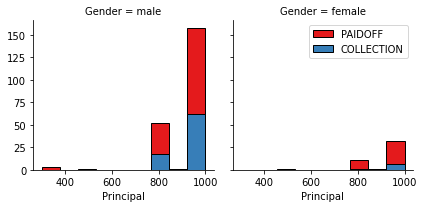

In [265]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

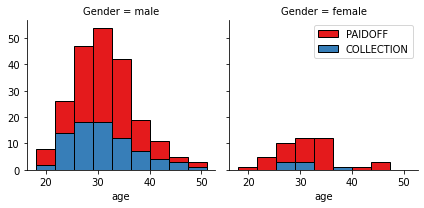

In [266]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


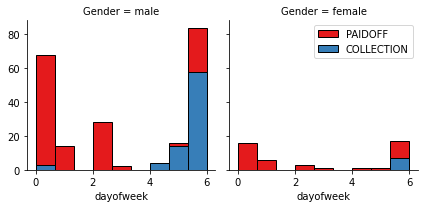

In [267]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [268]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [269]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [270]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [271]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [272]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [279]:
replace COLLECTION and PAIDOFF with 0 and 1
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
df.head()

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature[0:5]


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [280]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [281]:
y = df['loan_status'].values
y[0:15]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [282]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [210]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Training set:', X_train.shape, y_train.shape)
print ('Testing set:', X_test.shape, y_test.shape)



Training set: (276, 8) (276,)
Testing set: (70, 8) (70,)


In [314]:
#Calculate accuracy of different values of k
klist = 20
f1_acc_knn = np.zeros((klist-1))
jac_acc_knn = np.zeros((klist-1))
for k in range(1,klist):
    #Train the model and predict yhat for each value of k in klist
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    yhatknn = neigh.predict(X_test)

    jac_acc_knn[k-1] =  jaccard_score(y_test, yhatknn, average='weighted')
    f1_acc_knn[k-1] = f1_score(y_test, yhatknn) 


f1_acc_knn
#Save the best model for use below
neighKnnOpt = KNeighborsClassifier(n_neighbors = f1_acc_knn.argmax() +1).fit(X_train, y_train)

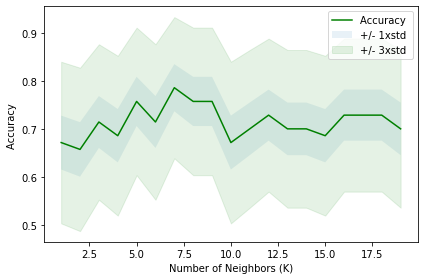

Value of K with highest f1 score is  7  with f1 score:  0.8672566371681416
Value of K with highest Jaccard score is  7  with Jaccard score:  0.6627869897959183


In [315]:
#plot the std and mean accuracy vs k
plt.plot(range(1,klist),mean_acc,'g')
plt.fill_between(range(1,klist),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,klist),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print ("Value of K with highest f1 score is ",f1_acc_knn.argmax() +1, " with f1 score: ", f1_acc_knn[f1_acc_knn.argmax()] )
print ("Value of K with highest Jaccard score is ",jac_acc_knn.argmax() +1, " with Jaccard score: ", jac_acc_knn[jac_acc_knn.argmax()] )

# Decision Tree


In [302]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.image as mpimg
from sklearn import tree

dlist = 20

f1_tree  = np.zeros((dlist-1)) 
jac_tree = np.zeros((dlist-1))

print("Decision tree comparison of accuracy using max depth values between 1 and",dlist)


Decision tree comparison of accuracy using max depth values between 1 and 20


In [311]:

# compare accuracy at various max_depth values 

for d in range(2,dlist):
    #Train the model and predict yhat
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth=d,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0,  random_state=None,
                        splitter='best')
    loanTree.fit(X_train, y_train)
    
    #prediction on the testing set with 'd' max_depth value
    loanpred = loanTree.predict(X_test)
    
    f1_tree[d-1]  = f1_score(y_test, loanpred, average='weighted')
    jac_tree[d-1] = jaccard_score(y_test,loanpred,average='weighted')
    
#save the optimum model for use below
loanTreeOpt =  DecisionTreeClassifier(criterion="entropy", max_depth=f1_tree.argmax() + 1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0,  random_state=None,
                        splitter='best').fit(X_train, y_train)


In [312]:
print ("Highest F1 score with max depth: ",f1_tree.argmax() + 1, " with F1-score: ", f1_tree[f1_tree.argmax()])
print ("Highest Jaccard score with max depth: ",f1_tree.argmax() + 1, " with Jaccard score: ", jac_tree[jac_tree.argmax()])

    
 

Highest F1 score with max depth:  14  with F1-score:  0.7414965986394557
Highest Jaccard score with max depth:  14  with Jaccard score:  0.6173469387755102


# Support Vector Machine


In [221]:
#fit the model (RBF method)
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score
import itertools

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

#predict
yhatsvm = clf.predict(X_test)
yhatsvm[0:5]

#Get the F1 Scorefrom sklearn.metrics import f1_score
f1score = f1_score(y_test, yhatsvm, average='weighted')
print (' ')

print ('F1 Score using RBF method is:',f1score)
print (' ')

#Get the Jacard score

jaccardscore = jaccard_score(y_test, yhatsvm, pos_label=1)
print ('Jaccard score using RBF method is: ',jaccardscore)

 
F1 Score using RBF method is: 0.7275882012724117
 
Jaccard score using RBF method is:  0.7272727272727273


In [223]:
## Linear method

clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train)

#predict
yhatsvm2 = clf2.predict(X_test)

f1score2 = f1_score(y_test, yhatsvm2, average='weighted')
print ('F1 Score with linear method is:',f1score)
print (' ')

#Get the Jacard score

jaccardscore2 = jaccard_score(y_test, yhatsvm2, pos_label=1)
print ('Jaccard score with linear method is: ',jaccardscore2)


F1 Score with linear method is: 0.7275882012724117
 
Jaccard score with linear method is:  0.7857142857142857


In [224]:
## Sigmoid method

clf3 = svm.SVC(kernel='linear')
clf3.fit(X_train, y_train)

#predict
yhatsvm3 = clf3.predict(X_test)

f1score3 = f1_score(y_test, yhatsvm3, average='weighted')
print ('F1 Score with sigmoid method is:',f1score3)
print (' ')

#Get the Jacard score

jaccardscore3 = jaccard_score(y_test, yhatsvm3, pos_label=1)
print ('Jaccard score with sigmoid method is: ',jaccardscore3)


F1 Score with sigmoid method is: 0.6914285714285714
 
Jaccard score with sigmoid method is:  0.7857142857142857


# Logistic Regression


In [320]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

# using liblinear
LRlin = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LRlin
#predict based on X_test set
yhatlr = LRlin.predict(X_test)

#get probabilities
yhatlr_prob = LR.predict_proba(X_test)
jaccardscorelr=jaccard_score(y_test, yhatlr, pos_label=1)
f1scorelr = f1_score(y_test, yhatlr, average='weighted')
loglosslr = log_loss(y_test, yhatlr_prob)
print(' ')
print ("The F1 Score using liblinear solver and 0.01 regularization is:",f1scorelr)
print ("The Jaccord Score using liblinear solver and 0.01 regularization is:",jaccardscorelr)
print ("The log loss score using liblinear solver and 0.01 regularization is is: ", log_loss(y_test, yhatlr_prob))


 
The F1 Score using liblinear solver and 0.01 regularization is: 0.6670522459996144
The Jaccord Score using liblinear solver and 0.01 regularization is: 0.6764705882352942
The log loss score using liblinear solver and 0.01 regularization is is:  0.5772287609479654


In [321]:
# using saga solver, same regularization
LRs = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
LRs
#predict based on X_test set
yhatlrs = LRs.predict(X_test)

#get probabilities
yhatlrs_prob = LRs.predict_proba(X_test)
jaccardscorelrs=jaccard_score(y_test, yhatlrs, pos_label=1)
f1scorelrs = f1_score(y_test, yhatlrs, average='weighted')
loglosslrs = log_loss(y_test, yhatlrs_prob)
print(' ')
print ("The F1 Score using saga solver and 0.01 regularization is:",f1scorelrs)
print ("The Jaccord Score using saga solver and 0.01 regularization is:",jaccardscorelrs)
print ("The log loss score using saga solver and and 0.01 regularization is: ", loglosslrs)

 


 
The F1 Score using saga solver and 0.01 regularization is: 0.6914285714285714
The Jaccord Score using saga solver and 0.01 regularization is: 0.7857142857142857
The log loss score using saga solver and and 0.01 regularization is:  0.4920169106863706


In [322]:
#loglinear solver, but change regularization to 0.05
LR5 = LogisticRegression(C=0.05, solver='liblinear').fit(X_train,y_train)
LR5
#predict based on X_test set
yhatlr5 = LR5.predict(X_test)

#get probabilities
yhatlr5_prob = LR5.predict_proba(X_test)
jaccardscorelr5=jaccard_score(y_test, yhatlr5, pos_label=1)
f1scorelr5 = f1_score(y_test, yhatlr5, average='weighted')
loglosslr5 = log_loss(y_test, yhatlr5_prob)
print(' ')
print ("The F1 Score using liblinear  solver and 0.05 regularization is:",f1scorelr5)
print ("The Jaccord Score using liblinear  solver and 0.05 regularization is:",jaccardscorelr5)
print ("The log loss score using liblinear  solver and and 0.05 regularization is: ", loglosslr5)



 
The F1 Score using liblinear  solver and 0.05 regularization is: 0.7048206031256878
The Jaccord Score using liblinear  solver and 0.05 regularization is: 0.7352941176470589
The log loss score using liblinear  solver and and 0.05 regularization is:  0.5102711178248118


# Model Evaluation using Test set


In [63]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [287]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-07-09 21:54:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-07-09 21:54:08 (112 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [293]:
test_df = pd.read_csv('loan_test.csv')
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)

#Feature Selection
FeatureTest = test_df[['Principal','terms','age','Gender','weekend']]
FeatureTest = pd.concat([FeatureTest,pd.get_dummies(test_df['education'])], axis=1)
FeatureTest.drop(['Master or Above'], axis = 1,inplace=True)
FeatureTest[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [295]:
# get test sets
Xtest = FeatureTest
ytest = test_df['loan_status'].values

#Normalize the data
Xtest= preprocessing.StandardScaler().fit(Xtest).transform(Xtest)

 
print ('Test set:', Xtest.shape, ytest.shape)
Xtest.shape[0]
ytest.shape[0]

Test set: (54, 8) (54,)


54

In [316]:
#KNN using the optimum k value found above
yhatknntest = neighKnnOpt.predict(Xtest)
jac_knntest  =  jaccard_score(ytest, yhatknntest, average='weighted')
f1_knntest  = f1_score(ytest, yhatknntest)
print('KNN using loan_test - Jaccard score:' , jac_knntest)
print('KNN using loan test - F1 score: ', f1_knntest)           
           

KNN using loan_test - Jaccard score: 0.5102564102564102
KNN using loan test - F1 score:  0.7906976744186046


In [313]:
#Decision Tree using the optimum max depth found above
loanpredtest = loanTreeOpt.predict(Xtest)
    
f1_treetest  = f1_score(ytest, loanpredtest, average='weighted')
jac_treetest = jaccard_score(ytest,loanpredtest,average='weighted')

print('Decision Tree using loan_test - Jaccard score: ', jac_treetest)
print('Decision Tree using loan_test - F1 score: ', f1_treetest)

Decision Tree using loan_test - Jaccard score:  0.5893719806763285
Decision Tree using loan_test - F1 score:  0.7302518270260205


In [317]:
#SVM using the optimum kernel parameter found above

yhatsvmtest = clf3.predict(Xtest)

f1svmtest = f1_score(ytest, yhatsvmtest, average='weighted')
jaccardsvmtest = jaccard_score(y_test, yhatsvm2, pos_label=1)
print ('SVM Jaccard score (linear kernel) is: ',jaccardsvmtest)
print ('SVM F1 Score (linear kernel) is:',f1svmtest)


Jaccard score (linear kernel) is:  0.7857142857142857
F1 Score (linear kernel) is: 0.6304176516942475


In [327]:
#Logistic Regression using the optimal method found above (based on log_loss)

#predict based on X_test set
yhatlr = LRlin.predict(Xtest)

#get probabilities
yhatlr_prob = LRlin.predict_proba(Xtest)
jaccardscorelrtest=jaccard_score(ytest, yhatlr, pos_label=1)
f1scorelrtest = f1_score(ytest, yhatlr, average='weighted')
loglosslrtest = log_loss(ytest, yhatlr_prob)

print ('Logistic Regression Jaccard score (linear kernel) is: ',jaccardscorelrtest)
print ('Logistic Regression F1 Score (linear kernel) is:',f1scorelrtest)
print ('Logistic Regression Log Loss score (linear kernel) is:',loglosslrtest)

Logistic Regression Jaccard score (linear kernel) is:  0.7358490566037735
Logistic Regression F1 Score (linear kernel) is: 0.6604267310789049
Logistic Regression Log Loss score (linear kernel) is: 0.5672153379912981


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.510   | 0.791    | NA      |
| Decision Tree      | 0.589   | 0.730    | NA      |
| SVM                | 0.786   | 0.630    | NA      |
| LogisticRegression | 0.736   | 0.660    | 0.567   |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
|---|---|---|---|
| 2020-10-27 | 2.1 | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27 | 2.0 | Malika Singla | Added lab to GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
